In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import os


%matplotlib inline
plt.style.use('seaborn-white')


## Data Wrangling

In [3]:

buys_raw=pd.read_csv('yoochoose-buys.csv',names=['sessionID','ts','itemID','price','cnt'])
print("buys train shape",buys_raw.shape)
buys_raw['status']=1


clicks_raw=pd.read_csv('yoochoose-clicks.csv',names=['sessionID','ts','itemID','cat'])
print("clicks_raw train shape",clicks_raw.shape)
clicks_raw['status']=0

union=pd.concat([clicks_raw, buys_raw], ignore_index=True).sort_values(by=['sessionID','itemID'])
print("union shape",union.shape)
union.head()

buys train shape (1150753, 5)


//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


clicks_raw train shape (33003944, 4)


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


union shape (34154697, 7)


,cat,cnt,itemID,price,sessionID,status,ts
1,0,NaN,214536500,NaN,1,0,2014-04-07T10:54:09.868Z
0,0,NaN,214536502,NaN,1,0,2014-04-07T10:51:09.277Z
2,0,NaN,214536506,NaN,1,0,2014-04-07T10:54:46.998Z
3,0,NaN,214577561,NaN,1,0,2014-04-07T10:57:00.306Z
9,0,NaN,214551617,NaN,2,0,2014-04-07T14:02:36.889Z


In [4]:
#datetime manipulation
union['ts']=pd.to_datetime(union.ts,infer_datetime_format=True)

In [5]:
union.head(12345).groupby(["itemID","sessionID"])["status"].nunique().max()

2

In [6]:
#NaN
union['cat']=union['cat'].fillna(method='ffill')


union['hour']=union.ts.dt.hour
union['weekday']=union['ts'].dt.dayofweek.astype(int)+1

In [7]:
union.head()

,cat,cnt,itemID,price,sessionID,status,ts,hour,weekday
1,0,NaN,214536500,NaN,1,0,2014-04-07 10:54:09.868000+00:00,10,1
0,0,NaN,214536502,NaN,1,0,2014-04-07 10:51:09.277000+00:00,10,1
2,0,NaN,214536506,NaN,1,0,2014-04-07 10:54:46.998000+00:00,10,1
3,0,NaN,214577561,NaN,1,0,2014-04-07 10:57:00.306000+00:00,10,1
9,0,NaN,214551617,NaN,2,0,2014-04-07 14:02:36.889000+00:00,14,1


## EDA

## Overview

In [8]:
buyID_num=buys_raw.sessionID.nunique() #
buyEvents=buys_raw.shape[0]
clickID_num=clicks_raw.sessionID.nunique()
itemClicks=clicks_raw.shape[0]
BC_ratio=buyID_num/clickID_num

In [9]:
print(r'''buyID_num:{} 
buyEvents:{} 
clickID_num:{} 
itemClicks:{} 
buy ratio of sessions :{}
buy ratio of clicks:{}'''
.format(buyID_num,buyEvents,clickID_num,itemClicks,BC_ratio,buyEvents/clickID_num))

buyID_num:509696 
buyEvents:1150753 
clickID_num:9249729 
itemClicks:33003944 
buy ratio of sessions :0.05510388466516154
buy ratio of clicks:0.1244093745881636


In [9]:
buyEvents/clickID_num

0.1244093745881636

# Statistics


## Buy Ratio Averaged for Time

In [10]:
# Buy ratio averaged for hour
hour_info=union.groupby(['hour','status'])['sessionID'].nunique().reset_index(name='count')
hour_click=hour_info[hour_info['status']==0]
hour_buy=hour_info[hour_info['status']==1]
hour_info=pd.merge(hour_click,hour_buy,on='hour')
hour_info['ratio']=hour_info['count_y']/hour_info['count_x']

In [11]:
# Buy ratio averaged for weekday
weekday_info=union.groupby(['weekday','status'])['sessionID'].nunique().reset_index(name='count')
weekday_click=weekday_info[weekday_info['status']==0]
weekday_buy=weekday_info[weekday_info['status']==1]
weekday_info=pd.merge(weekday_click,weekday_buy,on='weekday')
weekday_info['ratio']=weekday_info.count_y/weekday_info.count_x

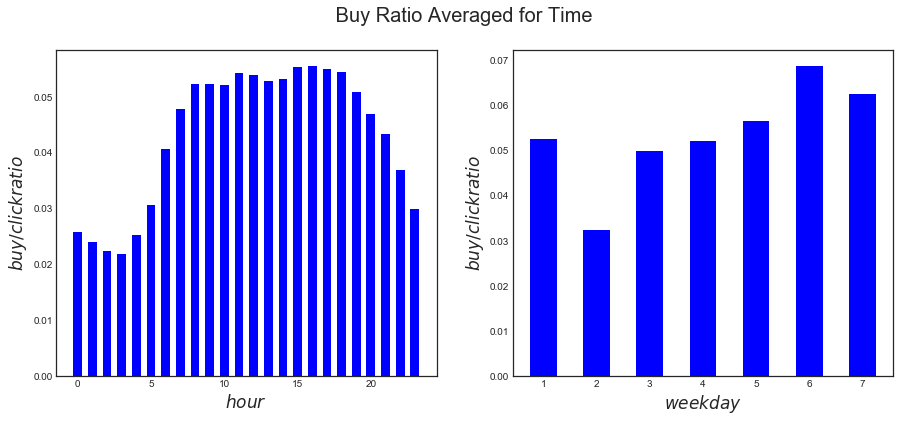

In [18]:
fig = plt.figure(figsize=(15,6))
fig.suptitle(' Buy Ratio Averaged for Time', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.bar(hour_info['hour'],hour_info['ratio'],width=0.6,color='b')


ax1.set_xlabel('$hour$', fontsize=17)
ax1.set_ylabel('$buy/click ratio$', fontsize=17)
ax2.bar(weekday_info['weekday'],weekday_info['ratio'],width=0.5,color='b')
ax2.set_xlabel('$weekday$', fontsize=17)
ax2.set_ylabel('$buy/click ratio$', fontsize=17)
plt.show()

In [ ]:
## buy ratio goes up at end of week and on weekend expecially on saturdays (tie this to pinterest)
## buy ratio highest in afternoon to evening before 7pm

## Buy Ratio Averaged for Category

In [19]:
def cat_classfier(value):
    if value=='S':
        return '13'
    elif len(value)<=2:
        return value
    else:
        return '14'

In [20]:
union['cat']=union.cat.astype(str).apply(cat_classfier).astype(int)
cat_info=union.groupby(['cat','status'])['sessionID'].nunique().reset_index(name='count').sort_values(by='cat')
cat_click=cat_info[cat_info['status']==0]
cat_buy=cat_info[cat_info['status']==1]
cat_info=pd.merge(cat_click,cat_buy,on='cat')
cat_info['ratio']=cat_info.count_y/cat_info.count_x

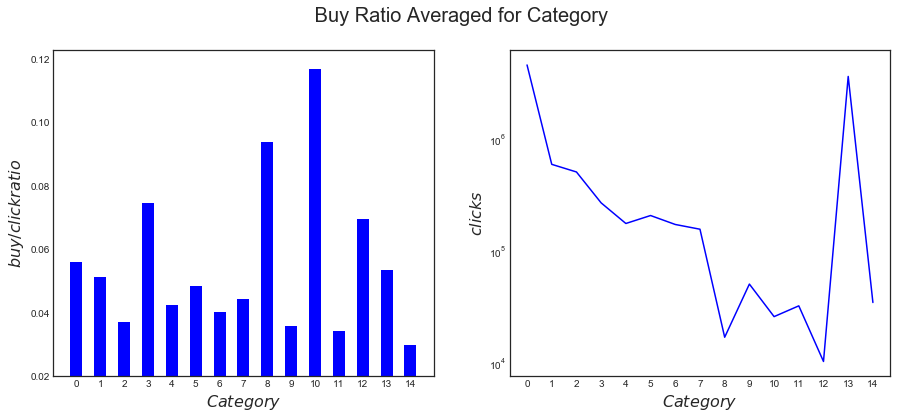

<Figure size 576x288 with 0 Axes>

In [21]:
fig = plt.figure(figsize=(15,6))
fig.suptitle(' Buy Ratio Averaged for Category', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


fig = plt.figure(figsize=(8,4))

ax1.bar(cat_info.cat,cat_info.ratio,width=0.5,color='b')
ax1.set_xticks(range(0,15))
ax1.set_ylim(0.02)
ax1.set_ylabel('$buy/click ratio$',fontsize=16)
ax1.set_xlabel('$Category$',fontsize=16)

ax2.plot(cat_info.count_x,color='b')
ax2.set_yscale('log')
ax2.set_ylabel('$clicks$',fontsize=16)
ax2.set_xticks(range(0,15))
ax2.set_xlabel('$Category$',fontsize=16)

plt.show()

In [ ]:
## 13 = special offer, 14 = brand, 0 = uncategorized, 1-12 = category like sports etc

## buy ratio highest for category 3, 8, 12 -- however they do not receive many clicks
## most clicks received by special offer -- which does not have a high buy ratio 